## import des librairies & chargement des dataset

In [1]:
import os.path

import pandas as pd
import seaborn as sns


In [2]:
FD_wIP = "./Fraud_Data_wIP.csv"


if os.path.isfile(FD_wIP):
    fd = pd.read_csv(FD_wIP)
    build_it = 0

else:
    fd = pd.read_csv("Fraud_Data.csv")
    geoip = pd.read_csv("IpAddress_to_Country.csv")
    build_it = 1


In [3]:
if not build_it :
    print("dataset with countries found and loaded from file.")
else:
    print("dataset with countries not found, now building it...")

dataset with countries found and loaded from file.


## Ajout des pays, via les addresses IP du dataset geoip.

In [149]:
if build_it :

        fd.ip_address = fd.ip_address.astype(float)

        # 
        # on va construire une liste de paires (index, pays)
        # puis joindre avec le dataset d'origine
        # 

        row_list = []

        # un itérateur pour chaque table
        geoip_gen = geoip.iterrows()
        fds_gen = fd.sort_values(by='ip_address').iterrows()

        # une fonction pour itérer sur la table fraud 
        def next_ip(g):
                i_fds, row_fds = next(g)
                ip = row_fds['ip_address']
                return i_fds, ip

        # initialisation
        l, u, c = tuple(next(geoip_gen)[1])
        i_fds, ip = next_ip(fds_gen)

        # parcours et identification du pays
        while(True):
                try:
                        if ip < l:                
                                i_fds, ip = next_ip(fds_gen)
                        
                        elif l <= ip <= u:
                                row_list.append((i_fds, c))
                                i_fds, ip = next_ip(fds_gen)
                        
                        elif ip > u:
                                l, u, c = tuple(next(geoip_gen)[1])
                
                except Exception as e :
                        break        


        pivot = pd.DataFrame(row_list, columns=['index', 'country'])
        pivot.set_index('index', inplace=True)

        # le resultat = notre dataset avec une colonne country en plus
        fd = fd.join(pivot)
        fd.to_csv("Fraud_Data_wIP.csv")

        # free memory
        del(geoip)
        del(row_list)

## cleaning, fillna, cast dates  

In [150]:
fd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Unnamed: 0      151112 non-null  int64  
 1   user_id         151112 non-null  int64  
 2   signup_time     151112 non-null  object 
 3   purchase_time   151112 non-null  object 
 4   purchase_value  151112 non-null  int64  
 5   device_id       151112 non-null  object 
 6   source          151112 non-null  object 
 7   browser         151112 non-null  object 
 8   sex             151112 non-null  object 
 9   age             151112 non-null  int64  
 10  ip_address      151112 non-null  float64
 11  class           151112 non-null  int64  
 12  country         129146 non-null  object 
dtypes: float64(1), int64(5), object(7)
memory usage: 15.0+ MB


In [151]:
# un nouvel user_id à chaque observation, cette variable n'apporte pas d'information 

fd.user_id.value_counts().max()

1

In [4]:
# remove columns with no useful information

todrop = ['user_id', 'Unnamed: 0']
fd.drop(todrop, axis=1, inplace=True)

In [5]:
# cast the columns with dates to datetime

fd.signup_time = pd.to_datetime(fd.signup_time)
fd.purchase_time = pd.to_datetime(fd.purchase_time)

In [6]:
# replace NaN in country
fd.country.fillna(value='n.a.', inplace=True)


In [7]:
fd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   signup_time     151112 non-null  datetime64[ns]
 1   purchase_time   151112 non-null  datetime64[ns]
 2   purchase_value  151112 non-null  int64         
 3   device_id       151112 non-null  object        
 4   source          151112 non-null  object        
 5   browser         151112 non-null  object        
 6   sex             151112 non-null  object        
 7   age             151112 non-null  int64         
 8   ip_address      151112 non-null  float64       
 9   class           151112 non-null  int64         
 10  country         151112 non-null  object        
dtypes: datetime64[ns](2), float64(1), int64(3), object(5)
memory usage: 12.7+ MB


In [156]:
fd.describe().T


,count,mean,std,min,25%,50%,75%,max
purchase_value,151112.0,3.693537e+01,1.832276e+01,9.000000,2.200000e+01,3.500000e+01,4.900000e+01,1.540000e+02
age,151112.0,3.314070e+01,8.617733e+00,18.000000,2.700000e+01,3.300000e+01,3.900000e+01,7.600000e+01
ip_address,151112.0,2.152145e+09,1.248497e+09,52093.496895,1.085934e+09,2.154770e+09,3.243258e+09,4.294850e+09
class,151112.0,9.364577e-02,2.913362e-01,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00


## exploration, feature eng. 

### Feature : device_id

certain device_id sont réutilisé plusieurs fois ?



In [157]:
# device id reuse

did = fd.device_id.value_counts()

did[did > 1].reset_index().groupby('device_id').count()


,index
device_id,
2,5327
3,90
4,4
5,13
6,29
7,50
8,69
9,78
10,92


In [158]:
# feature engineering => add a column (device_id_seen) with sum of same-device_id usage 

In [159]:
did

KIPFSCNUGOLDP    20
ITUMJCKWEYNDD    20
ZUSVMDEZRBDTX    20
CQTUVBYIWWWBC    20
EQYVNEGOFLAWK    20
                 ..
GSPTLJBOXWJBD     1
JMZVQAPFOJSVA     1
SUKOSEVTXNFZQ     1
WEAUHCTNFYUJT     1
LNUCUOYKTXQCK     1
Name: device_id, Length: 137956, dtype: int64

In [160]:
fd = fd.join(did, on='device_id', rsuffix="_did")
del(did)

fd.rename(columns={'device_id_did': 'device_id_seen'}, inplace=True)

fd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   signup_time     151112 non-null  datetime64[ns]
 1   purchase_time   151112 non-null  datetime64[ns]
 2   purchase_value  151112 non-null  int64         
 3   device_id       151112 non-null  object        
 4   source          151112 non-null  object        
 5   browser         151112 non-null  object        
 6   sex             151112 non-null  object        
 7   age             151112 non-null  int64         
 8   ip_address      151112 non-null  float64       
 9   class           151112 non-null  int64         
 10  country         151112 non-null  object        
 11  device_id_seen  151112 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(4), object(5)
memory usage: 13.8+ MB


In [161]:
# il y a une corrélation forte entre le fait que le device_id soit ré-utilisé et la classe 

fd.corr()

,purchase_value,age,ip_address,class,device_id_seen
purchase_value,1.000000,0.002370,-0.000328,0.001011,0.003829
age,0.002370,1.000000,0.001140,0.006624,0.012160
ip_address,-0.000328,0.001140,1.000000,-0.005208,-0.007585
class,0.001011,0.006624,-0.005208,1.000000,0.670837
device_id_seen,0.003829,0.012160,-0.007585,0.670837,1.000000


In [162]:
# ce sont peut etre (en partie) des achats utilisés pour des tests.
fd[fd.device_id == 'ITUMJCKWEYNDD']

,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,device_id_seen
83,2015-01-10 23:23:25,2015-01-10 23:23:26,38,ITUMJCKWEYNDD,Ads,Safari,M,43,3.874758e+09,1,n.a.,20
3165,2015-01-10 23:23:20,2015-04-28 00:12:59,38,ITUMJCKWEYNDD,Ads,Safari,M,43,3.874758e+09,0,n.a.,20
5505,2015-01-10 23:23:37,2015-01-10 23:23:38,38,ITUMJCKWEYNDD,Ads,Safari,M,43,3.874758e+09,1,n.a.,20
29782,2015-01-10 23:23:29,2015-01-10 23:23:30,38,ITUMJCKWEYNDD,Ads,Safari,M,43,3.874758e+09,1,n.a.,20
34981,2015-01-10 23:23:22,2015-01-10 23:23:23,38,ITUMJCKWEYNDD,Ads,Safari,M,43,3.874758e+09,1,n.a.,20
35526,2015-01-10 23:23:21,2015-01-10 23:23:22,38,ITUMJCKWEYNDD,Ads,Safari,M,43,3.874758e+09,1,n.a.,20
35570,2015-01-10 23:23:31,2015-01-10 23:23:32,38,ITUMJCKWEYNDD,Ads,Safari,M,43,3.874758e+09,1,n.a.,20
72653,2015-01-10 23:23:35,2015-01-10 23:23:36,38,ITUMJCKWEYNDD,Ads,Safari,M,43,3.874758e+09,1,n.a.,20
73883,2015-01-10 23:23:28,2015-01-10 23:23:29,38,ITUMJCKWEYNDD,Ads,Safari,M,43,3.874758e+09,1,n.a.,20
74920,2015-01-10 23:23:36,2015-01-10 23:23:37,38,ITUMJCKWEYNDD,Ads,Safari,M,43,3.874758e+09,1,n.a.,20


### Feature : age

- faire des classes d'age
- voir les caractéristiques (moyennes ?) par classe d'age (purchase value et autres)
- # age group, outlier purchase_value


In [124]:

def age_classe(a, r=5, maxi=55):
    if int(a) > maxi :
        return str(maxi+1) + '+'
    else:
        return str(r * (a//r)) + '-' + str(min(r * (a//r) + r - 1, maxi))

fd['age_group'] = fd.age.apply(lambda x : age_classe(x, maxi=54))

In [164]:
#_ = sns.distplot(fd.age)

In [165]:
#_ = sns.relplot(x='age', y='purchase_value', data=fd, hue='class')

In [166]:
fd.groupby('age_group')['purchase_value'].mean()

age_group
15-19    36.464361
20-24    37.291862
25-29    36.681963
30-34    36.917630
35-39    36.826871
40-44    37.287728
45-49    36.868234
50-54    36.758604
55+      37.537450
Name: purchase_value, dtype: float64

In [167]:
#_ = sns.barplot(x='age_group', y='purchase_value', data=fd.iloc[:100,:], hue='class')

In [126]:
fd.groupby(['country', 'age_group'])['purchase_value'].mean().reset_index()


,country,age_group,purchase_value
0,Afghanistan,20-24,18.000000
1,Afghanistan,25-29,49.000000
2,Afghanistan,30-34,40.500000
3,Afghanistan,35-39,23.000000
4,Albania,15-19,43.000000
...,...,...,...
1128,n.a.,35-39,36.564672
1129,n.a.,40-44,36.953160
1130,n.a.,45-49,36.489276
1131,n.a.,50-54,37.646179


In [169]:
fd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   signup_time     151112 non-null  datetime64[ns]
 1   purchase_time   151112 non-null  datetime64[ns]
 2   purchase_value  151112 non-null  int64         
 3   device_id       151112 non-null  object        
 4   source          151112 non-null  object        
 5   browser         151112 non-null  object        
 6   sex             151112 non-null  object        
 7   age             151112 non-null  int64         
 8   ip_address      151112 non-null  float64       
 9   class           151112 non-null  int64         
 10  country         151112 non-null  object        
 11  device_id_seen  151112 non-null  int64         
 12  age_group       151112 non-null  object        
dtypes: datetime64[ns](2), float64(1), int64(4), object(6)
memory usage: 15.0+ MB


In [171]:
# ip addr reuse
ipid = fd['ip_address'].value_counts()
ipid[ipid > 1].reset_index().groupby('ip_address').count()

,index
ip_address,
2,1
3,2
4,4
5,13
6,30
7,50
8,71
9,82
10,89


### frequence des achats (ou delta avec le dernier achat)

In [44]:
# delta time register to purchase

# hour of purchase (detect off business hour or night purchases, depends on tz)

# day of purchase ?


# resample purchases to get a frequency of purchases, then by country, and/or hour, -> detect fraudulent activities



In [41]:
fd['signup_day'] = fd.signup_time.apply(lambda x: x.day_name())
fd['signup_hour'] = fd.signup_time.apply(lambda x: x.hour)


In [44]:
fd['purchase_day'] = fd.purchase_time.apply(lambda x: x.day_name())
fd['purchase_hour'] = fd.purchase_time.apply(lambda x: x.hour)


In [66]:
fd['delta_sec'] = (fd.purchase_time - fd.signup_time).apply(lambda x : (x.days * 86400) + x.seconds)

In [82]:
fd.set_index('purchase_time').resample('1d').mean()

,purchase_value,age,ip_address,class,signup_hour,purchase_hour,delta_sec
purchase_time,,,,,,,
2015-01-01,33.994746,34.232925,2.156572e+09,0.998249,11.036778,11.057793,7.897548e+01
2015-01-02,37.244565,32.968750,2.108375e+09,0.985054,11.875000,11.930707,1.006931e+03
2015-01-03,36.743728,33.607527,2.292969e+09,0.982079,12.537634,12.589606,2.047384e+03
2015-01-04,33.350548,34.913928,2.207562e+09,0.965571,11.798122,11.860720,4.834089e+03
2015-01-05,37.351211,32.543253,2.329743e+09,0.961938,11.339100,11.384083,6.436052e+03
...,...,...,...,...,...,...,...
2015-12-12,40.400000,33.866667,2.022918e+09,0.000000,15.333333,9.066667,1.025381e+07
2015-12-13,46.714286,32.071429,1.914621e+09,0.071429,11.857143,9.928571,1.025590e+07
2015-12-14,35.285714,37.428571,2.305584e+09,0.000000,10.285714,12.428571,1.028945e+07


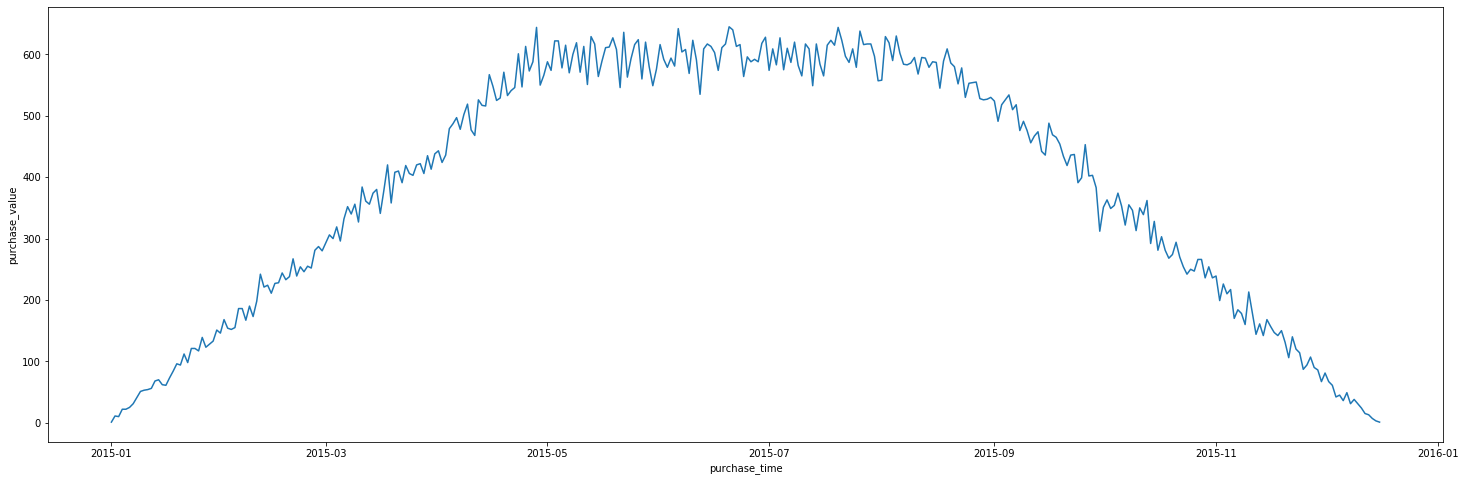

In [154]:
from matplotlib import pyplot
fig, ax = pyplot.subplots(figsize=(25,8))

tmp = fd[fd['class']==0].set_index('purchase_time').resample('1d').count()
_ = sns.lineplot(x=tmp.index, y='purchase_value', data=tmp)

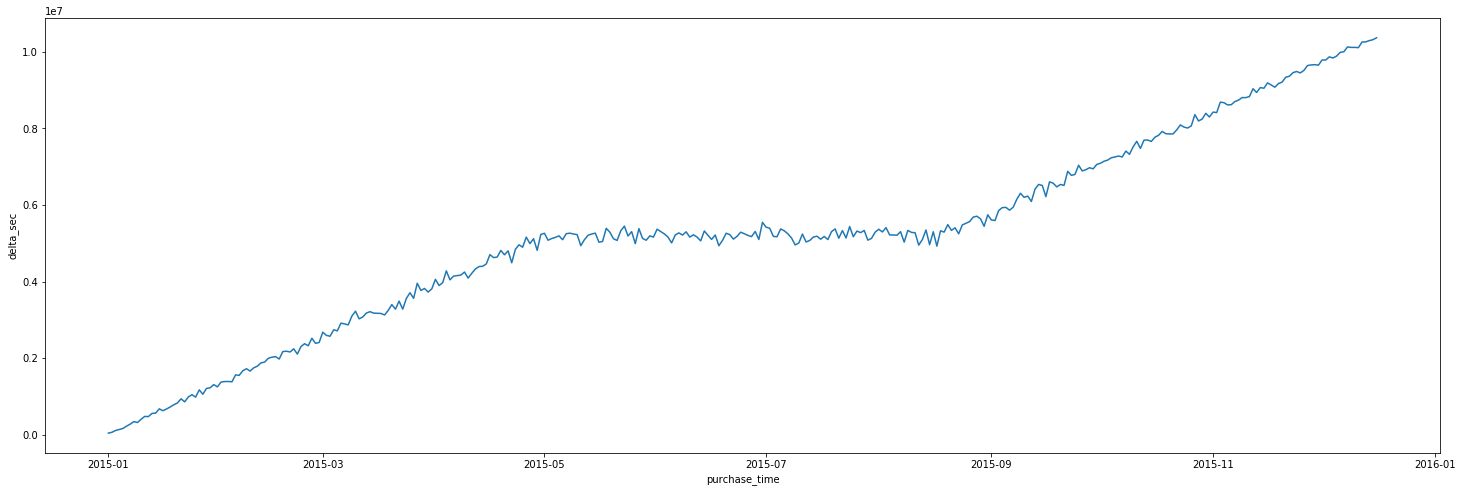

In [109]:
from matplotlib import pyplot
fig, ax = pyplot.subplots(figsize=(25,8))

tmp = fd[fd['class']==0].set_index('purchase_time').resample('1d').mean()
_ = sns.lineplot(x=tmp.index, y='delta_sec', data=tmp)

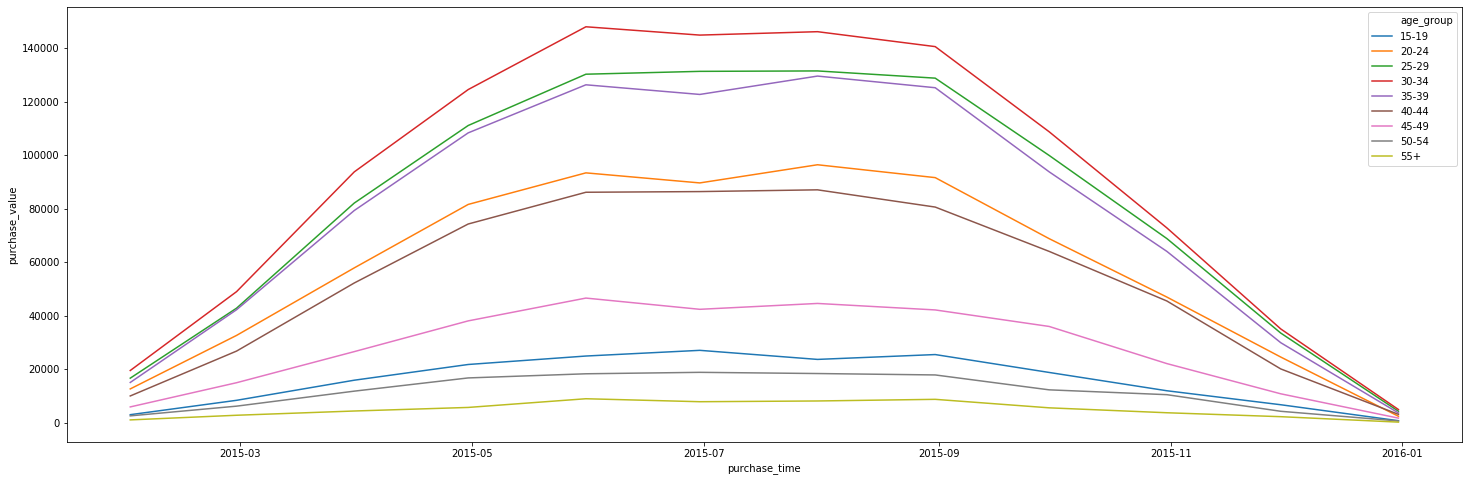

In [132]:
from matplotlib import pyplot
fig, ax = pyplot.subplots(figsize=(25,8))

tmp = fd[fd['class']==0].set_index('purchase_time').groupby('age_group').resample('1m').sum().reset_index()

_ = sns.lineplot(x='purchase_time', y='purchase_value', data=tmp, hue='age_group')


In [151]:
fd[fd['class']==0].groupby('purchase_hour').mean()


,purchase_value,age,ip_address,class,signup_hour,delta_sec
purchase_hour,,,,,,
0,36.526007,33.134032,2.145100e+09,0.0,11.560092,5.217922e+06
1,36.925194,33.113973,2.160649e+09,0.0,11.434898,5.130635e+06
2,36.677150,33.074023,2.164267e+09,0.0,11.410599,5.176026e+06
3,36.521561,33.197810,2.125316e+09,0.0,11.538672,5.185707e+06
4,37.116619,33.028298,2.153266e+09,0.0,11.485400,5.171385e+06
5,37.123913,33.176638,2.152710e+09,0.0,11.525830,5.170803e+06
6,36.750432,33.148980,2.146185e+09,0.0,11.422226,5.145544e+06
7,36.971611,33.143542,2.182565e+09,0.0,11.579489,5.161216e+06
8,36.749782,33.116397,2.155724e+09,0.0,11.626416,5.227735e+06


In [155]:
fd.info()


150000 * 130000

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 17 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   signup_time     151112 non-null  datetime64[ns]
 1   purchase_time   151112 non-null  datetime64[ns]
 2   purchase_value  151112 non-null  int64         
 3   device_id       151112 non-null  object        
 4   source          151112 non-null  object        
 5   browser         151112 non-null  object        
 6   sex             151112 non-null  object        
 7   age             151112 non-null  int64         
 8   ip_address      151112 non-null  float64       
 9   class           151112 non-null  int64         
 10  country         151112 non-null  object        
 11  signup_day      151112 non-null  object        
 12  signup_hour     151112 non-null  int64         
 13  purchase_day    151112 non-null  object        
 14  purchase_hour   151112 non-null  int

19500000000

### source, browser, sex

voir si ces features ont un interet pour notre prédiction de classe


### country

- pays important vs non-importants 

- tendances / spécifiques par pays ?

- frequence d'achat et purchase_value moyenne par pays ?



